First, load the data, from the supplied data file

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import regex as re
import seaborn as sns

In [9]:
# Import the data
df = pd.read_csv("../data/artist_data.csv")  #..(relative path, parents) vs C:\Users(absolute path)

In [6]:
# Set some global options so we always see all of the columns and rows when we print something out
pd.set_option('display.max_columns', 100) # 100 cols
pd.set_option('display.max_rows', 50) # 50 rows

In [8]:
print(df.head)

<bound method NDFrame.head of          id                    name  gender      dates  yearOfBirth   
0     10093  Abakanowicz, Magdalena  Female  born 1930       1930.0  \
1         0     Abbey, Edwin Austin    Male  1852–1911       1852.0   
2      2756        Abbott, Berenice  Female  1898–1991       1898.0   
3         1  Abbott, Lemuel Francis    Male  1760–1803       1760.0   
4       622          Abrahams, Ivor    Male  born 1935       1935.0   
...     ...                     ...     ...        ...          ...   
3527  12542         Zorio, Gilberto    Male  born 1944       1944.0   
3528   2186              Zox, Larry    Male  born 1936       1936.0   
3529    621   Zuccarelli, Francesco    Male  1702–1788       1702.0   
3530   2187        Zuloaga, Ignacio    Male  1870–1945       1870.0   
3531   2188         Zyw, Aleksander    Male  1905–1995       1905.0   

      yearOfDeath                    placeOfBirth            placeOfDeath   
0             NaN                       

In [9]:
# Shape and data types of the data
print(df.shape) 
print("The dataframe has",df.shape[0],"rows and", df.shape[1],"columns")
print(df.dtypes) # The data types of all of the columns

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number]) # Select numeric data types
numeric_cols = df_numeric.columns.values # Give the column names to a new variable
print("The column names are",df.columns.values)
print("The numeric columns are", numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print("The non-numeric columns are",non_numeric_cols)

(3532, 9)
The dataframe has 3532 rows and 9 columns
id                int64
name             object
gender           object
dates            object
yearOfBirth     float64
yearOfDeath     float64
placeOfBirth     object
placeOfDeath     object
url              object
dtype: object
The column names are ['id' 'name' 'gender' 'dates' 'yearOfBirth' 'yearOfDeath' 'placeOfBirth'
 'placeOfDeath' 'url']
The numeric columns are ['id' 'yearOfBirth' 'yearOfDeath']
The non-numeric columns are ['name' 'gender' 'dates' 'placeOfBirth' 'placeOfDeath' 'url']


Identify missing data 

<Axes: >

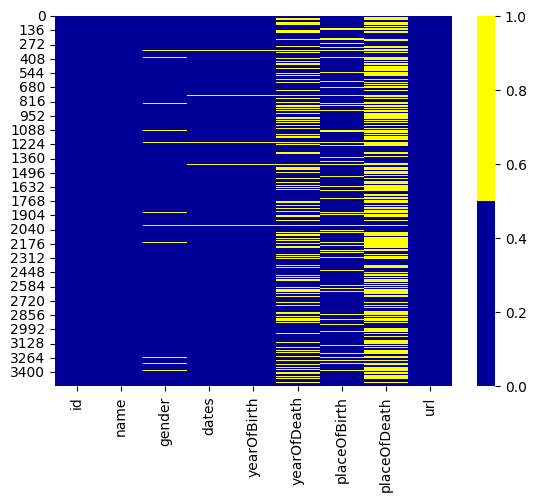

In [11]:
cols = df.columns[:30] # Select the first 30 columns
colours = ['#000099', '#ffff00'] # Specify the colours, where yellow is missing and blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours)) # Make a heatmap
